Whilst many attributes can fall under this umbrella of data, the primary goal is to obtain good building footprints for a region of interest. If there is additional data, (e.g. LiDAR height data) or categorisation of buildings (e.g. retail, commercial, residential), then wombat will provide that information as well. 

First what we need are good building footprints.

## Open Street Map

OpenStreetMap (OSM) is a free, open geographic database updated and maintained by a community of volunteers via open collaboration. There are hundreds of tools to interact with this dataset and obtain their building information. 

![Microsoft Building Footprints](img/OSM-NYC-footprints.png)

### pyrosm

One of the main tools to obtain building information is via [pyrosm](https://github.com/HTenkanen/pyrosm/). As per their documentation:

> Pyrosm is a Python library for reading OpenStreetMap from Protocolbuffer Binary Format -files (*.osm.pbf) into Geopandas GeoDataFrames. Pyrosm makes it easy to extract various datasets from OpenStreetMap pbf-dumps including e.g. road networks, buildings, Points of Interest (POI), landuse, natural elements, administrative boundaries and much more. Fully customized queries are supported which makes it possible to parse any kind of data from OSM, even with more specific filters.

This access is as follows.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

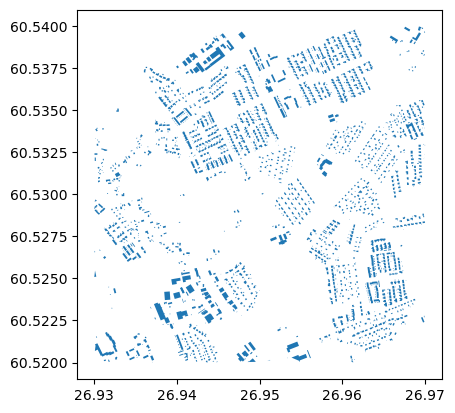

In [202]:
%load_ext autoreload
%autoreload 2
from pyrosm import OSM
from pyrosm import get_data
fp = get_data("test_pbf",directory=os.path.join(os.environ['WOMBAT_DATA_PATH'],"pbf"))
# Initialize the OSM parser object
osm = OSM(fp)
buildings = osm.get_buildings()
buildings.plot()


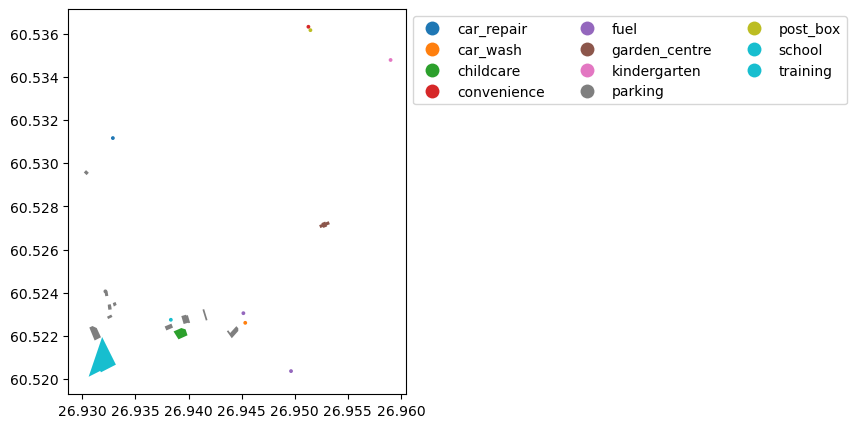

In [136]:
# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

# Plot
ax = pois.plot(column='poi_type', markersize=3, 
               figsize=(5,5), 
               legend=True, 
               legend_kwds=dict(loc='upper left', 
                                ncol=3, 
                                bbox_to_anchor=(1, 1)))

Whilst this dataset has great potential, the downside is that it is incomplete.

### Incompleteness

The challenge with OpenStreetMap is that whilst it contains a wealth of data, ultimately it is incomplete. For our purposes, it is incomplete in two ways that impact the utility of it in `wombat`.

To demonstrate this, one only has to zoom to any suburb >10km from the CBD and the structures marked falls of drastically. We need a method to make up this drop off in data, particularly outside the CBD of the major cities. 

We can directy examine the extent of the incompletness by comparing to Google's building footprints next to OpenStreetMap.

In [204]:
%load_ext autoreload
%autoreload 2
import wombat

# create a city
city = wombat.City("Brisbane")

# initialise wombat
w = wombat.Wombat(dataset_path=os.environ['WOMBAT_DATA_PATH'],
                  zoom=18,
                  center=[city.lat+0.009,city.lon], # offset slightly from the CBD
                  draw_control=False,
                  measure_control=False,
                  fullscreen_control=False,
                  attribution_control=False,
                  zoom_control=False,
                  scrollWheelZoom=True,
                  dragging=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
# compare left (OpenStreetMap) and right (Google) building footprints
w.split_map(left_layer="OpenStreetMap", 
            right_layer="ROADMAP",
            left_label="OpenStreetMap",
            right_label="Google")
w

## Enter Microsoft 

To make up the difference, `wombat` combines the OSM building footprints with [footprints generated by Microsoft](https://github.com/microsoft/GlobalMLBuildingFootprints) from aerial imagery using AI. They also have a similar project for [road detection](https://github.com/microsoft/RoadDetections). 

![Microsoft Building Footprints](img/footprints-sample.png)

They report very good results:

| Metric | Value |
| --- | :---: |
| Precision | 98.59% |
| Recall | 64.95% |

| IoU | Shape distance | Rotation error [deg] |
| :---: | :---: | :---: |
|  0.79 | 0.44 | 4.46 |

| Error category | 35.05% Gap |
| --- | :---: |
| Very small buildings | 15.4% |
| Connected buildings | 14.0% |
| DNN | 2.8% |
| Various | 2.1% |
| Polygonization | 0.7% |

The estimate ~1% false postive ratio in 1000 randomly sampled buildings from the entire output corpus.
More details [here](https://github.com/microsoft/AustraliaBuildingFootprints/blob/main/README.md).

Let's now check how this looks in Wombat.

## Integration Into Wombat (Microsoft + OSM)

In [238]:
# restart
w = wombat.Wombat(dataset_path=os.environ['WOMBAT_DATA_PATH'])
w.set_city("Brisbane")
w.Buildings.load(load_osm=True,       # load OSM building footprints for city selected
                 load_msft=True,      # load MSFT building footprints for city selected
                 load_combined=False) # combined building footprints ( OSM ∪ Microsoft)

Setting: Brisbane
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loading OSM...


Note, the buildings being loaded are being drawn from a custom `geojson` files that consist of all objects within the SA3 boundary of a given city. See the section on [Boundary](/boundary) for more detail.

In [207]:
# we can calculate the 
w.Buildings.calc_overlaps()

> [ BUILDINGS ] Calculating overlaps...
> [ BUILDINGS ] Calculating non-overlaps...
> [ BUILDINGS ] Percent Objects Overlap: 1.33


In [208]:
# buildings in Microsoft dataset NOT in OSM dataset
w.Buildings.buildings_msft_not_in_osm

id  is_osm                                           geometry
0            0   False  POLYGON ((152.22450 -26.90248, 152.22431 -26.9...
1            1   False  POLYGON ((152.27290 -26.98819, 152.27299 -26.9...
2            2   False  POLYGON ((152.28372 -26.89451, 152.28384 -26.8...
3            3   False  POLYGON ((152.28873 -26.89542, 152.28877 -26.8...
4            4   False  POLYGON ((152.32116 -26.57606, 152.32117 -26.5...
...        ...     ...                                                ...
986218  986218   False  POLYGON ((153.30060 -27.68641, 153.30062 -27.6...
986219  986219   False  POLYGON ((153.30959 -27.69305, 153.30976 -27.6...
986220  986220   False  POLYGON ((153.31708 -27.68730, 153.31707 -27.6...
986221  986221   False  POLYGON ((153.38573 -27.70633, 153.38572 -27.7...
986222  986222   False  POLYGON ((153.38971 -27.69086, 153.38985 -27.6...

[878207 rows x 3 columns]

In [209]:
# buildings overall ( intersection: OSM ∪ Microsoft)
w.Buildings.buildings

id  is_osm                                           geometry
0       4282941    True  POLYGON ((153.12079 -27.38351, 153.12088 -27.3...
1       8040447    True  POLYGON ((153.02759 -27.47551, 153.02767 -27.4...
2       8040448    True  POLYGON ((153.02812 -27.47568, 153.02821 -27.4...
3       8040449    True  POLYGON ((153.02770 -27.47632, 153.02755 -27.4...
4       8040451    True  POLYGON ((153.02762 -27.47632, 153.02746 -27.4...
...         ...     ...                                                ...
986218   986218   False  POLYGON ((153.30060 -27.68641, 153.30062 -27.6...
986219   986219   False  POLYGON ((153.30959 -27.69305, 153.30976 -27.6...
986220   986220   False  POLYGON ((153.31708 -27.68730, 153.31707 -27.6...
986221   986221   False  POLYGON ((153.38573 -27.70633, 153.38572 -27.7...
986222   986222   False  POLYGON ((153.38971 -27.69086, 153.38985 -27.6...

[1042597 rows x 3 columns]

In [211]:
# check out a region of the city to compare the Microsoft (blue) vs. the OpenStreetMap building footprints
w.Buildings.add_buildings(w,which='all',
                          nbuildings=None,
                          bounding_box=True,
                          bbox_width=2,
                          center_latlon=[city.lat+0.1,city.lon])

## Performing Integration For Each City

This exercise involves the following steps:

1. Load the OSM buildings (via pyrosm) for a specific Greater Capital City area.
2. Get buildings from the bounded region.
3. Get Microsoft's inferred buildings for the same region.
4. Calculate which buildings are not in the OSM GCC area.
5. Output a merged list of buildings for each GCC area.

We want to take the OSM structures as a first priority and only fill out with those from the Microsoft dataset. The OSM structures are higher quality, especially in the densely packed CBD regions and so this is a nice complementary method that plays to both of the source's strengths.

In [232]:
from datetime import datetime
current_date = datetime.now()
cdate = current_date.isoformat().split("T")[0]
cdate

'2023-08-27'

In [233]:
data = []

for city in wombat.capitals:
    w.set_city(city)
    w.Buildings.load(load_osm=True,  # load OSM building footprints for city selected
                 load_msft=True,     # load MSFT building footprints for city selected
                 load_combined=True) # load combined building footprints ( OSM ∪ Microsoft)
    
    num_osm = w.Buildings.buildings_osm.shape[0]
    num_msft = w.Buildings.buildings_msft.shape[0]
    num_unique_combined = w.Buildings.buildings.shape[0]
    frac_overlap = num_osm/num_msft
    
    item = {"City":city,
            "Number (OSM)":num_osm,
            "Number (MSFT)":num_msft,
            "Union":num_unique_combined,
            "Overlap":round(frac_overlap,2),
            "Filename":os.path.basename(w.Buildings.combined_footprints_filename),
            "Updated": cdate}

    data.append(item)

Setting: Brisbane
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loading OSM...
> [ BUILDINGS ] Loading combined footprints...
Setting: Sydney
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loading OSM...
> [ BUILDINGS ] Loading combined footprints...
Setting: Melbourne
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loading OSM...
> [ BUILDINGS ] Loading combined footprints...
Setting: Hobart
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loading OSM...
> [ BUILDINGS ] Loading combined footprints...
Setting: Adelaide
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loading OSM...
> [ BUILDINGS ] Loading combined footprints...
Setting: Darwin
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loading OSM...
> [ BUILDINGS ] Loading combined footprints...
Setting: Canberra
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loading OSM...
> [ BUILDINGS ] Loading combined footprints...
Setting: Perth
> [ BUILDINGS ] Loading Microsoft...
> [ BUILDINGS ] Loadin

In [237]:
import pandas as pd
pd.DataFrame(data).set_index("City").sort_values("Overlap")

Number (OSM)  Number (MSFT)    Union  Overlap           Filename  \
City                                                                          
Brisbane         164390         986223  1042597     0.17   Brisbane.geojson   
Perth            154828         798880   821089     0.19      Perth.geojson   
Sydney           328831        1271291  1402473     0.26     Sydney.geojson   
Canberra          36642         142426   154338     0.26   Canberra.geojson   
Darwin            15140          53370    55604     0.28     Darwin.geojson   
Melbourne        537634        1654907  1870734     0.32  Melbourne.geojson   
Adelaide         218158         561012   590700     0.39   Adelaide.geojson   
Hobart           117141         120479   147613     0.97     Hobart.geojson   

              Updated  
City                   
Brisbane   2023-08-27  
Perth      2023-08-27  
Sydney     2023-08-27  
Canberra   2023-08-27  
Darwin     2023-08-27  
Melbourne  2023-08-27  
Adelaide   2023-08-27  
Hobart     2023-08-27

These data will enable the statistical calculations of packages like [urbanity](https://github.com/winstonyym/urbanity) to be much more faithfully representative of the regions being studied. More to come soon.

## Overture Maps

During the course of preparing this documentation, [Overture Maps](https://overturemaps.org/) has released a phenomenal dataset of places, buildings and roads of the entire plant. The dataset is ~200GB and is accessible either via a AWS/Azure query or direct download (parquet). The buildings component of what they have produced, seems to be similar same methodology as described above (OSM + Microsoft), except done on the entire planet. 

This data will be incorporated, not only for buildings, but other data in the coming months (e.g. POIs etc.). 

If you'd like to access this data yourself, [check out these instructions](https://github.com/OvertureMaps/data).